In [1]:
!pip install jax jaxlib

  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.6.1-py3-none-any.whl (2.4 MB)
Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl (89.1 MB)
Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)


# State Estimation in the Budyko-Sellers energy balance model using algorithmic differentiation in JAX

This notebook runs the Budyko-Sellers 1-D energy balance model and uses its gradient to reduce the cost function J, which represents the mismatch between zonal mean temperature from NCEP and the model. 

<font color='blue'>__[Notes on the Budyko-Sellers Model](https://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture14%20--%20Diffusive%20energy%20balance%20model.html)__</font>




In [2]:
import jax.numpy as jnp
from jax import grad

import numpy as np
import jax.numpy as jnp
from jax import grad, lax,jit
import sys
N = 100
num_controls = 3
from functools import partial
import netCDF4 as nc
import matplotlib.pyplot as plt

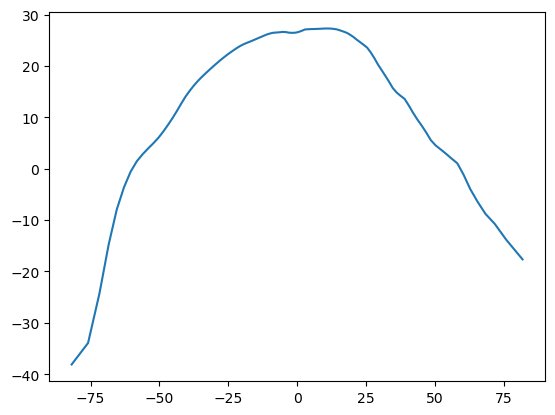

In [3]:
## Import NCEP temperature, get zonal mean and extrapolate to grid size
N = 100

XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])
plt.plot(LAT,Ts_annual_interp)

In [4]:
def budyko_sellers_jax(XXS):
    MAX_ITER = 100000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 + XXS[:N]

    # Initial temperature
    T_init = 288.0 + 60.0 * (1.0 - X**2) - 20.0

    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25
    def step(_,state):
        T, XXS = state['T'], state['XXS']
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
        ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + 1*XXS[N:2*N]
        ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1*XXS[2*N:]
        emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return {'T': T_new, 'XXS': XXS}
    init_state = {'T': T_init, 'XXS': XXS}
    state_final = lax.fori_loop(0, MAX_ITER, step, init_state)
    T_final,XXS = state_final['T'],state_final['XXS']
    alpha_raw =  alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
    logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + 1*XXS[N:2*N]
    ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1*XXS[2*N:]
    emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))
    return J,T_final,ALPHA,emiss

def cost_fxn(XXS):
    J,_,_,_ = budyko_sellers_jax(XXS)
    return J

In [5]:
from jax import grad

grad_J = grad(cost_fxn)

XXS = jnp.zeros(N*num_controls)
dJ_dXXS = grad_J(XXS) 

In [6]:
## gradient descent
XXS = jnp.zeros(N*num_controls)
a = 0.1
max_iter = 100
J = 1000
i = 0
while((J > 0) & (i < max_iter)):
    J,T,alpha,emiss = budyko_sellers_jax(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - a*g
    i = i+1

Cost function at step 0: 105.24237060546875
Cost function at step 1: 82.54769897460938
Cost function at step 2: 66.67703247070312
Cost function at step 3: 54.106422424316406
Cost function at step 4: 44.67194366455078
Cost function at step 5: 38.23352813720703
Cost function at step 6: 34.31833267211914
Cost function at step 7: 33.02821350097656
Cost function at step 8: 40.806739807128906
Cost function at step 9: 64.04004669189453
Cost function at step 10: 53.55153274536133
Cost function at step 11: 65.5351333618164
Cost function at step 12: 48.915016174316406
Cost function at step 13: 64.08196258544922
Cost function at step 14: 46.814598083496094
Cost function at step 15: 62.297183990478516
Cost function at step 16: 45.19477462768555
Cost function at step 17: 60.53737258911133
Cost function at step 18: 43.75664520263672
Cost function at step 19: 58.85055160522461
Cost function at step 20: 42.46186065673828
Cost function at step 21: 57.23651885986328
Cost function at step 22: 41.27751541

Text(0.5, 0, 'Latitude')

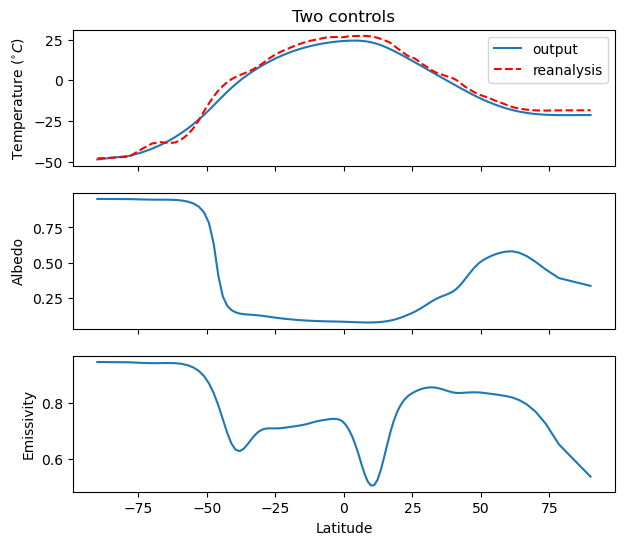

In [7]:
import matplotlib.pyplot as plt
lat = np.arcsin(np.linspace(-1.0, 1.0, 100)) * 180.0 / jnp.pi
T_ncep = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two controls')
ax.plot(lat, T-273)
ax.plot(lat,T_ncep,'--r')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss)
ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')